In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 39.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm # 통계 라이브러리.
from pmdarima.arima import auto_arima # ARIMA
from statsmodels.tsa.arima_model import ARIMA # tsa = Time Series Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as SNS # 시각화
%matplotlib inline

import itertools

데이터 로딩

In [3]:
data = pd.read_csv('/content/drive/MyDrive/TimeSeries/AirPassengers.csv')

In [4]:
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [5]:
data = data.rename(columns={'Month': 'month', '#Passengers': 'Passengers'})
data['month'] = pd.to_datetime(data['month']) # month라는 컬럼을 datetime (시간)
data = data.set_index('month') # month 컬럼을 인덱스로 설정.
data

,Passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


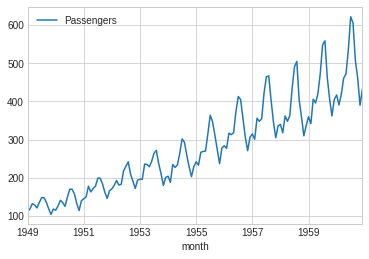

In [6]:
data.plot()

정상성 체크 - 시계열 분해

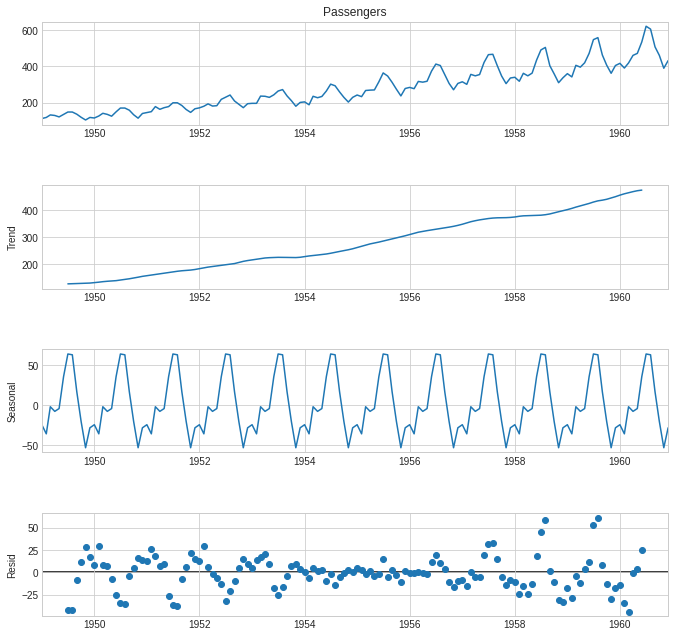

In [7]:
## Decomposition tsa = time series analysis => s
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='additive') # 시계열 분해, decompostion
fig = decomposition.plot() # 시각화
fig.set_size_inches(10, 10)
plt.show() # show

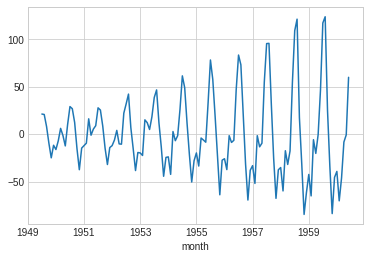

In [12]:
# detrend
(data['Passengers'] - decomposition.trend).plot()

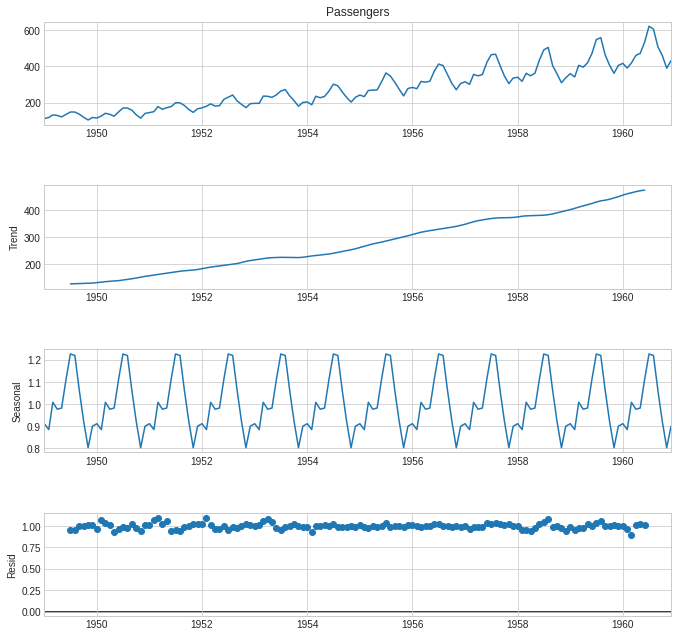

In [13]:
## Decomposition
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative') # 시계열 분해를 한 다음에, decompostion이라는 변수에 결과를 저장.
fig = decomposition.plot() # 결과에서 그림을 추출.
fig.set_size_inches(10, 10)
plt.show()

In [ ]:
decomposition.seasonal.dropna()

month
1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
                ...   
1960-08-01    1.219911
1960-09-01    1.060492
1960-10-01    0.921757
1960-11-01    0.801178
1960-12-01    0.898824
Name: seasonal, Length: 144, dtype: float64

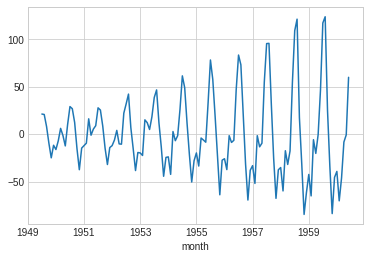

In [ ]:
## detrend

((data['Passengers'] - decomposition.trend ).plot())

정상화 과정

In [14]:
import numpy as np # numpy <= 숫자를 다루는 라이브러리.
log_data = np.log(data.copy())

In [15]:
log_data

,Passengers
month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


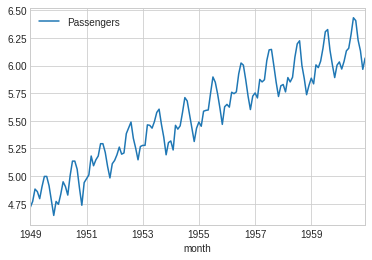

In [16]:
log_data.plot()

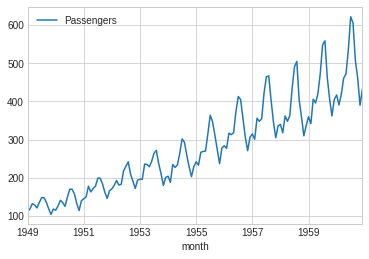

In [ ]:
data.plot()

train, test 분할

In [18]:
# split => 시계열에서는 다르게 => shuffle=False
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

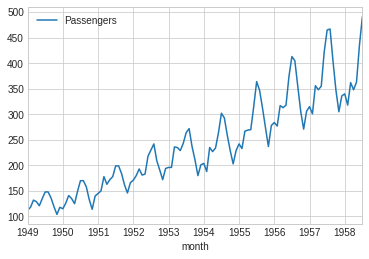

In [ ]:
train_data.plot()

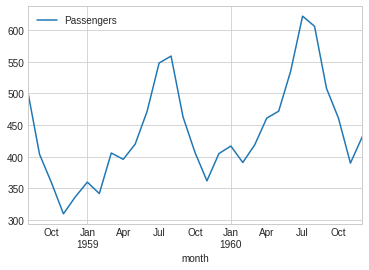

In [ ]:
test_data.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


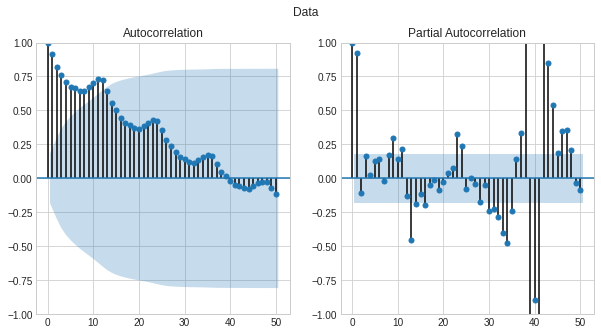

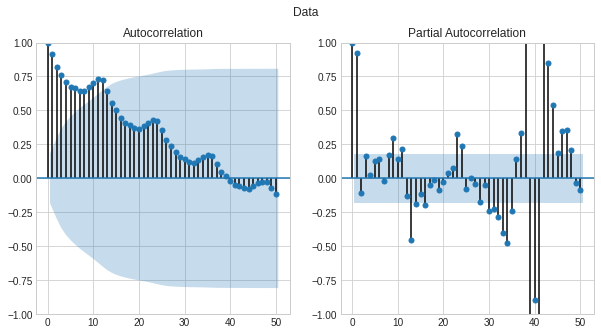

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=50, ax=ax[1])

쪼갠 train, test를 정상화 과정

In [ ]:
train_data

,Passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-03-01,362
1958-04-01,348
1958-05-01,363


In [19]:
import numpy as np
log_train_data = np.log(train_data.copy()) # train_data를 로그를 씌움
log_test_data = np.log(test_data.copy()) # test_data를 로그를 씌움
diff_train_data = log_train_data['Passengers'].diff() # 차분 수행 (xt - xt-1)
diff_train_data.dropna(inplace=True) # 맨 앞에 값은 차분이 불가하기 때문에, 삭제

diff_train_data

month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1958-03-01    0.129593
1958-04-01   -0.039442
1958-05-01    0.042200
1958-06-01    0.180943
1958-07-01    0.121098
Name: Passengers, Length: 114, dtype: float64

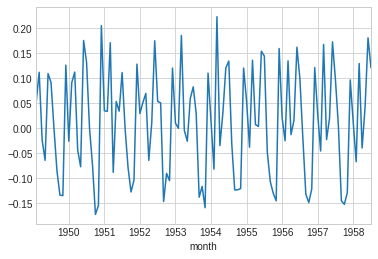

In [20]:
# 로그를 씌우고 차분을 한 데이터.
diff_train_data.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


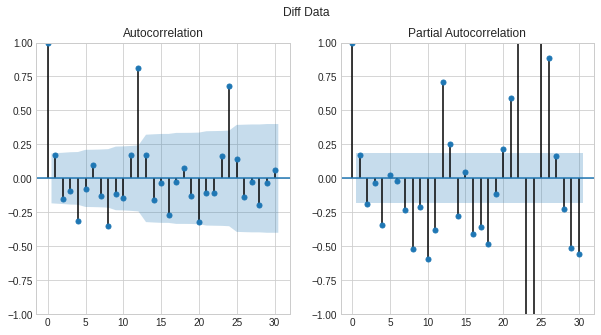

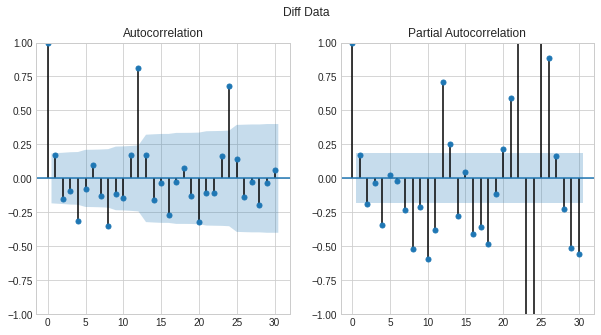

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Diff Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

모델링 파트

In [21]:
                  # 모델링할 데이터.           # p (AR의 윈도우), d (차분), q (MA의 윈도우)
model = SARIMAX(diff_train_data.values, order=(1,0,0) # AR(1) order=(1,1,1) => ARIMA(1,1,1), order(0,0,1) => MA(1)
#, seasonal_order=(2,1,1,12) (p,d,q, 계절의 주기)
) # AR(1)
history = model.fit() # 모델의 학습
history.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  97.865
Date:                Sat, 20 Nov 2021   AIC                           -191.729
Time:                        11:27:45   BIC                           -186.257
Sample:                             0   HQIC                          -189.508
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1809      0.102      1.772      0.076      -0.019       0.381
sigma2         0.0105      0.002      5.382      0.000       0.007       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 6.64
Prob(Q):                              0.81   Prob(JB):                         0.04
Heteroskedasticity (H):               1.12   Skew:                             0.29
Prob(H) (two-sided):                  0.72   Kurtosis:                         1.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

최적의 ARIMA 모델을 찾기

In [22]:
p = range(0, 3) # 0,1,2
d = range(0, 2) # 0,1
q = range(0, 3) # 0,1,2


# AR(1), ARMA(1,1), MA(1), AR(2), ARMA(2,1)........

              # p,d,q 범위를 가지고 가능한 모든 조합을 찾는 것.
pdq = list(itertools.product(p, d, q))

aic = [] # ARIMA 모델들의 결과를 저장.

for i in pdq:
  model = SARIMAX(log_train_data.values, order=(i))
  model_fit = model.fit()
  aic.append(model_fit.aic)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist

In [23]:
# aic <= 낮으면 낮을수록 좋은값.
aic

[717.1617082774054,
 565.5890015717575,
 423.5798328251519,
 -189.9569652598799,
 -193.42956079196583,
 -196.56903479266782,
 -181.71747987838341,
 -185.19237594312187,
 -188.33293549752415,
 -191.729306727382,
 -197.2214635080905,
 -199.93967530248176,
 -183.49084701633566,
 -182.13245604490635,
 -182.69456100403625,
 -193.15545546526397,
 -199.69933231709734,
 -199.30514648279535]

In [24]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 2), -199.93967530248176)]

In [25]:
opt_model = SARIMAX(log_train_data.values, order=optimal[0][0]) # 최적 파라미터를 넣어서, opt_model
opt_model_fit = opt_model.fit() # opt_model의 실행결과를 opt_model_fit

opt_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 103.970
Date:                Sat, 20 Nov 2021   AIC                           -199.940
Time:                        11:29:40   BIC                           -188.995
Sample:                             0   HQIC                          -195.498
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5049      0.163      3.103      0.002       0.186       0.824
ma.L1         -0.3353      0.174     -1.928      0.054      -0.676       0.006
ma.L2         -0.4228      0.103     -4.118      0.000      -0.624      -0.222
sigma2         0.0094      0.002      4.842      0.000       0.006       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 7.38
Prob(Q):                              0.47   Prob(JB):                         0.03
Heteroskedasticity (H):               1.12   Skew:                             0.08
Prob(H) (two-sided):                  0.73   Kurtosis:                         1.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

모델링 끝.
평가

In [26]:
                                   # 예측할 길이.
pred = opt_model_fit.get_forecast(len(log_test_data))

In [27]:
pred # 예측 결과

In [ ]:
test_data

,Passengers
month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396


In [28]:
pred.predicted_mean

array([6.15518574, 6.08548517, 6.05029139, 6.03252106, 6.02354833,
       6.01901774, 6.01673012, 6.01557504, 6.0149918 , 6.01469731,
       6.01454861, 6.01447353, 6.01443562, 6.01441648, 6.01440681,
       6.01440193, 6.01439947, 6.01439823, 6.0143976 , 6.01439728,
       6.01439712, 6.01439704, 6.014397  , 6.01439698, 6.01439697,
       6.01439696, 6.01439696, 6.01439696, 6.01439696])

In [29]:
np.exp(pred.predicted_mean) # 실제 예측 값 (로그를 씌운)

array([471.15434693, 439.43295874, 424.23662982, 416.76439533,
       413.04160508, 411.17451708, 410.23498098, 409.76139882,
       409.52248164, 409.40189859, 409.34102631, 409.31029363,
       409.29477671, 409.28694201, 409.2829861 , 409.28098867,
       409.27998011, 409.27947086, 409.27921373, 409.2790839 ,
       409.27901834, 409.27898524, 409.27896853, 409.27896009,
       409.27895583, 409.27895367, 409.27895259, 409.27895204,
       409.27895176])

In [ ]:
# lower bound
pred.conf_int()[:,0]

array([5.96505758, 5.79290393, 5.71763889, 5.67683435, 5.65136583,
       5.6332895 , 5.61895411, 5.60659966, 5.59535489, 5.58478002,
       5.57464854, 5.56484057, 5.55529002, 5.54595828, 5.536821  ,
       5.52786141, 5.51906693, 5.51042744, 5.50193437, 5.49358018,
       5.48535808, 5.47726193, 5.46928607, 5.46142526, 5.45367465,
       5.44602973, 5.43848628, 5.43104038, 5.42368833])

In [ ]:
# upper bound
np.exp(pred.conf_int()[:,1])

array([569.81623029, 588.78812465, 591.66694995, 594.78962976,
       599.28113303, 604.70817312, 610.63911083, 616.80344619,
       623.05121011, 629.3040994 , 635.52325676, 641.69075281,
       647.79949164, 653.84784811, 659.83686363, 665.76879922,
       671.64640008, 677.4725302 , 683.24999739, 688.98147543,
       694.66947499, 700.31633818, 705.92424428, 711.49522007,
       717.03115168, 722.53379647, 728.0047942 , 733.44567735,
       738.85788044])

In [30]:
predicted_values = np.exp(pred.predicted_mean)
pred_lb = np.exp(pred.conf_int()[:,0]) # lb => lower bound
pred_ub = np.exp(pred.conf_int()[:,1]) # ub => upper bound

In [31]:
predicted_values

array([471.15434693, 439.43295874, 424.23662982, 416.76439533,
       413.04160508, 411.17451708, 410.23498098, 409.76139882,
       409.52248164, 409.40189859, 409.34102631, 409.31029363,
       409.29477671, 409.28694201, 409.2829861 , 409.28098867,
       409.27998011, 409.27947086, 409.27921373, 409.2790839 ,
       409.27901834, 409.27898524, 409.27896853, 409.27896009,
       409.27895583, 409.27895367, 409.27895259, 409.27895204,
       409.27895176])

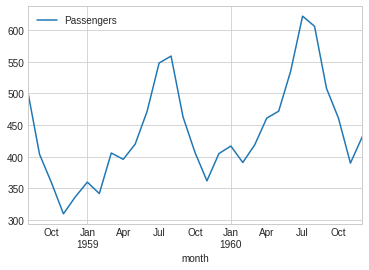

In [32]:
test_data.plot()

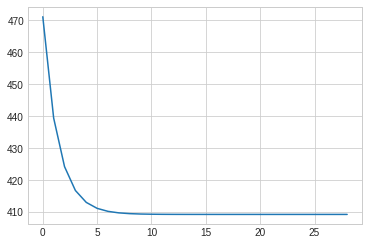

In [33]:
plt.plot(predicted_values)

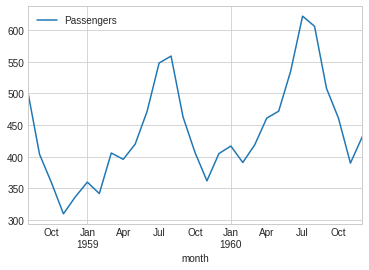

In [ ]:
test_data.plot()

Text(0.5, 0.98, 'ARIMA (1, 1, 2) Prediction Result (r2 score: -0.14274262640190605')

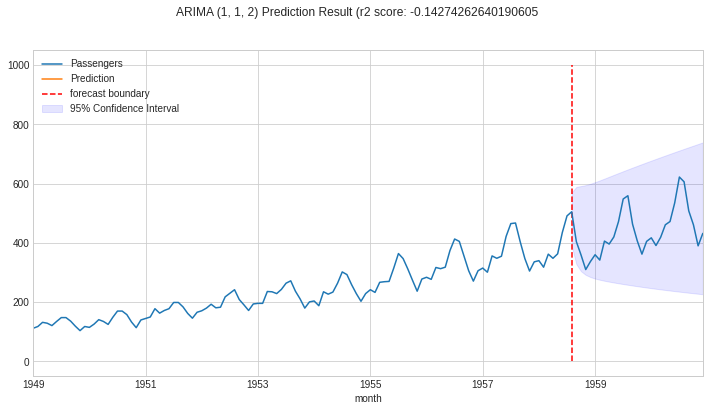

In [34]:
fig = plt.figure(figsize = (12,6)) # 큰 그림 하나 준비.
ax = fig.add_subplot(111)

pred_index = list(test_data.index) # 예측 시작 기준점.
r2 = r2_score(test_data, predicted_values)

data.plot(ax=ax)
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='forecast boundary') # 예측을 시작할 기준점에다가 라인을 그림
ax.fill_between(pred_index, pred_lb, pred_ub, color='b', alpha=0.1, label='95% Confidence Interval') # 예측 시작한 후 기준 점 다음에, 상한 / 하한.
ax.plot(pred_index, predicted_values, label='Prediction')
ax.legend(loc='upper left')
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2}")
# plt.show()

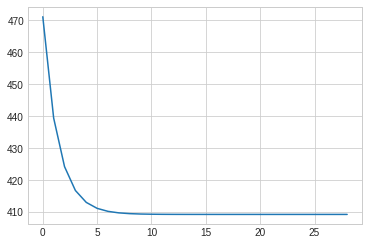

In [ ]:
plt.plot(predicted_values)

In [35]:
                                           # ARIMA 차수     # 계절성 차트의 차수.                        
opt_model = SARIMAX(log_train_data.values, order=(2,1,1), seasonal_order=(2,1,1,12))
opt_model_fit = opt_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [36]:
pred = opt_model_fit.get_forecast(len(test_data))

In [37]:
pred.conf_int()

array([[6.10480398, 6.24931164],
       [5.95882737, 6.13361261],
       [5.80252232, 6.00519157],
       [5.66051463, 5.88730001],
       [5.76833222, 6.01694511],
       [5.78030044, 6.04896737],
       [5.72195617, 6.00928157],
       [5.85836906, 6.16321294],
       [5.82446418, 6.14587311],
       [5.84285553, 6.18001665],
       [6.0040178 , 6.3562273 ],
       [6.10859199, 6.47523275],
       [6.07751149, 6.4773353 ],
       [5.93291824, 6.35689641],
       [5.77745411, 6.22482307],
       [5.63718525, 6.10668167],
       [5.74336562, 6.23400392],
       [5.75475259, 6.26565689],
       [5.69447881, 6.22487554],
       [5.83044379, 6.37964152],
       [5.79457462, 6.36195069],
       [5.81313682, 6.39812662],
       [5.97482381, 6.57691228],
       [6.0780902 , 6.69680498],
       [6.04813052, 6.699711  ],
       [5.90200731, 6.5792209 ],
       [5.74514577, 6.4475396 ],
       [5.60377207, 6.3303839 ],
       [5.70745568, 6.45751437]])

Text(0.5, 0.98, 'ARIMA (1, 1, 2) Prediction Result (r2 score: 0.9620119182763479')

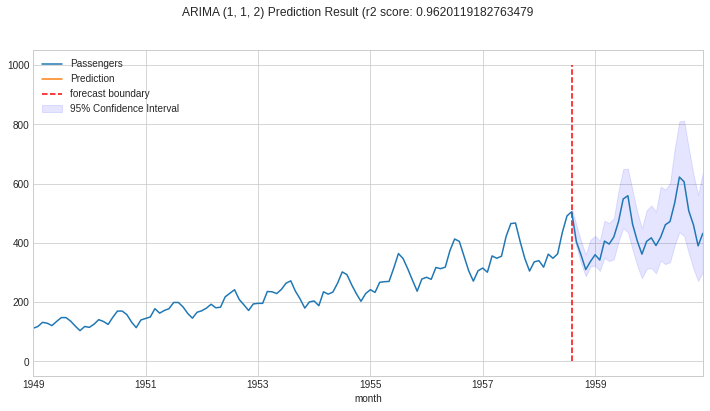

In [38]:
pred = opt_model_fit.get_forecast(len(log_test_data))
predicted_values = np.exp(pred.predicted_mean)
pred_lb = np.exp(pred.conf_int()[:,0]) # 하한선
pred_ub = np.exp(pred.conf_int()[:,1]) # 상한선

pred_index = list(test_data.index)
r2 = r2_score(test_data, predicted_values)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
data.plot(ax=ax)
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='forecast boundary')
ax.fill_between(pred_index, pred_lb, pred_ub, color='b', alpha=0.1, label='95% Confidence Interval')
ax.plot(pred_index, predicted_values, label='Prediction')
ax.legend(loc='upper left')
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2}")
# plt.show()

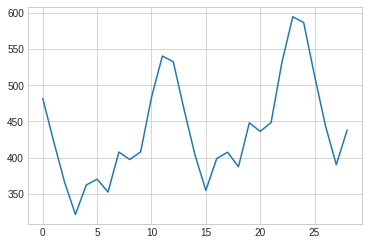

In [39]:
plt.plot(predicted_values)

In [40]:
# ARIMA 모델의 차수를 찾는 과정을 자동화.
# p,d,q <= 어떤게 최적인지 찾는 부분을 자동화.

auto_arima_model = auto_arima(diff_train_data, start_p = 1, start_q = 1,
                              max_p = 3, max_q = 3, m = 12, seasonal=True,
                              d = 1, D=1,
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-233.715, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-307.007, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-288.960, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-310.708, Time=1.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-311.336, Time=2.46 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=-310.739, Time=4.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-312.661, Time=2.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-314.644, Time=0.69 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-316.470, Time=0.69 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-314.650, Time=0.97 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-312.638, Time=1.71 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-264.571, Time=0.26 sec
 ARIMA(2,1,0)(0,1,1)[12]     

In [ ]:
pred = opt_model_fit.get_forecast(len(log_test_data))
predicted_values = np.exp(pred.predicted_mean)
pred_lb = np.exp(pred.conf_int()[:,0])
pred_ub = np.exp(pred.conf_int()[:,1])

pred_index = list(test_data.index)
r2 = r2_score(test_data, predicted_values)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
data.plot(ax=ax)
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='forecast boundary')
ax.fill_between(pred_index, pred_lb, pred_ub, color='b', alpha=0.1, label='95% Confidence Interval')
ax.plot(pred_index, predicted_values, label='Prediction')
ax.legend(loc='upper left')
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2}")
# plt.show()

NameError: ignored

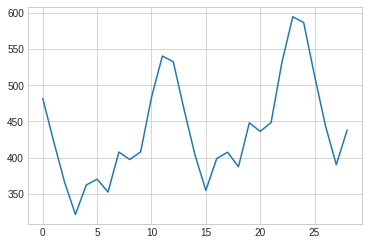

In [ ]:
# plt.plot(predicted_values)

## ADF (Augumented Dickey-Fuller) TEST

귀무가설(H0): non-stationary.


대체가설 (H1): stationary.

## p-hacking의 문제점

https://www.hani.co.kr/arti/science/science_general/888909.html

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3774514#:~:text=Lasse%20Heje%20Pedersen,-AQR%20Capital%20Management&text=Several%20papers%20argue%20that%20financial,which%20leads%20to%20different%20conclusions

https://www.youtube.com/watch?v=dzi1CSvzCoU


In [ ]:
 from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(train_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.356889
p-value: 0.917052
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [ ]:
result = adfuller(np.log(train_data))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.574027
p-value: 0.496626
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


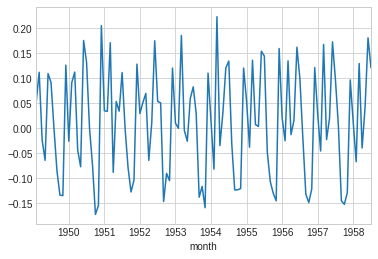

In [ ]:
diff_train_data.plot()

In [ ]:
result = adfuller(diff_train_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.635851
p-value: 0.085812
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [ ]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
        values 0, 1, ..., maxlag.
    
        * If "